References:


*   https://www.kaggle.com/code/nawidsayed/lightgbm-and-cnn-3rd-place-solution/notebook
*   https://www.kaggle.com/code/mks2192/list-of-fake-samples-and-public-private-lb-split/notebook





##### Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
import scipy.ndimage
from sklearn import linear_model
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.ensemble import StackingClassifier
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
RAND_STATE = 47
np.random.seed(RAND_STATE)

In [ ]:
folder = '../'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### Get Updated clean and split files

In [ ]:
def get_train_test(tr = 'X_train.csv', te = 'X_test_all.csv'):
    # Returns a sample of original dataset
    # of 100k records of class 0 and all records of class 1
    # along with val and test datasets
    df = pd.read_csv(folder + tr)
    # test_df = pd.read_csv(folder + 'X_test.csv')
    test_all_df = pd.read_csv(folder + te)
    # Splitting for train and val
    X_train, X_val, y_train, y_val = train_test_split(df.iloc[:, 3:],
                                                    df.target,
                                                    test_size=0.2, 
                                                    random_state=RAND_STATE,
                                                    stratify = df['target'])
    X_test_all = test_all_df.iloc[:, 3:]
    
    class_dict = {0 : 100000,
                  1 :  y_train.value_counts()[1]}
    
    rus = RandomUnderSampler(sampling_strategy = class_dict,
                             random_state = RAND_STATE) 
    X_res, y_res = rus.fit_resample(X_train, y_train)
    X_res.to_csv(folder+'charan/X_res.csv')
    y_res.to_csv(folder+'charan/y_res.csv')
    
    del df, test_all_df
#   return X_train, X_val, y_train, y_val, X_test_all
    return X_res, X_val, y_res, y_val, X_test_all

##### Initializing models for stacking

In [ ]:
def get_stacked_model():
    # Logistic Regression
    lr_stack = linear_model.LogisticRegression(C=0.1, 
                                            class_weight='balanced', 
                                            penalty='l1', 
                                            solver= 'saga', 
                                            random_state=RAND_STATE,
                                            verbose = 1)
    

    # Random Forest
#     rf_stack = RandomForestClassifier(max_features='auto', 
#                                     max_depth=15, 
#                                     min_samples_split=15,
#                                     class_weight='balanced', 
#                                     bootstrap=True ,
#                                     random_state=RAND_STATE,
#                                     verbose = 1)
    # XGBoost Classifier
    xgb_stack = XGBClassifier(max_depth=5, 
                        n_estimators=200,
                        random_state=RAND_STATE,
                        verbosity = 1,
                        scale_pos_weight = 8,
                        learning_rate = .05)
    
    lgbm_stack = LGBMClassifier(bagging_fraction=0.331, bagging_freq=5,
                                boost='gbdt', boost_from_average='false',
                                class_weight='balanced', feature_fraction=0.045,
                                learning_rate=0.0083, metric='auc',
                                min_data_in_leaf=80,
                                min_sum_hessian_in_leaf=10.0, num_leaves=13,
                                num_threads=8, objective='binary',
                                random_state=RAND_STATE,
                                tree_learner='serial', verbosity=1)

    # Initializing the base layer of models
    base_estimators = [('xgb', lgbm_stack),
                       ('lr', lr_stack)]

    # Initiating the stacking classifier using xgboost as the final estimator
    model = StackingClassifier(estimators=base_estimators,
                               final_estimator=xgb_stack,
                               passthrough = True,
                               verbose = 1,
                               n_jobs = 3)
    return model

##### Fitting the Model

In [ ]:
X_train, X_val, y_train, y_val, X_test_all = get_train_test()

In [ ]:
model = get_stacked_model()

In [ ]:
model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/charan/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.38976692
Epoch 3, change: 0.24217417
Epoch 4, change: 0.17689428
Epoch 5, change: 0.14537652
Epoch 6, change: 0.11813794
Epoch 7, change: 0.10071531
Epoch 8, change: 0.08944758
Epoch 9, change: 0.07820564
Epoch 10, change: 0.07022125
Epoch 11, change: 0.06239945
Epoch 12, change: 0.05643258
Epoch 13, change: 0.05154705
Epoch 14, change: 0.04713413
Epoch 15, change: 0.04362312
Epoch 16, change: 0.04062441
Epoch 17, change: 0.03776488
Epoch 18, change: 0.03506185
Epoch 19, change: 0.03284459
Epoch 20, change: 0.03078487
Epoch 21, change: 0.02916804
Epoch 22, change: 0.02753647
Epoch 23, change: 0.02624520
Epoch 24, change: 0.02495647
Epoch 25, change: 0.02374986
Epoch 26, change: 0.02274656
Epoch 27, change: 0.02161439
Epoch 28, change: 0.02076872
Epoch 29, change: 0.01983106
Epoch 30, change: 0.01910933
Epoch 31, change: 0.01830364
Epoch 32, change: 0.01763178
Epoch 33, change: 0.01694360
Epoch 34, change: 0.01632976
Epoch 35, change: 0.015

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.045
[LightGBM] [Warning] bagging_fraction is set=0.331, subsample=1.0 will be ignored. Current value: bagging_fraction=0.331
[LightGBM] [Info] Number of positive: 12862, number of negative: 80000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0

[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  2.0min finished


max_iter reached after 69 seconds


/Users/charan/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/charan/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min finished
/Users/charan/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/charan/miniforge3/lib/python3.9/site-packages/sklearn/lin

[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.045
[LightGBM] [Warning] bagging_fraction is set=0.331, subsample=1.0 will be ignored. Current value: bagging_fraction=0.331
[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=5

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=0.1,
                                                   class_weight='balanced',
                                                   penalty='l1',
                                                   random_state=47,
                                                   solver='saga', verbose=1)),
                               ('lgbm',
                                LGBMClassifier(bagging_fraction=0.331,
                                               bagging_freq=5, boost='gbdt',
                                               boost_from_average='false',
                                               class_weight='balanced',
                                               feature_fraction=0.045,
                                               learning_rate=0.0083,
                                               metric='auc',
                                               min_data_in_leaf=80,
            

##### Evaluate model

In [ ]:
print('Training AuC: \n')
model.score(X_train, y_train)

Training AuC: 



0.8113423732317924

In [ ]:
print('Validation AuC: \n')
model.score(X_val, y_val)

Validation AuC: 



0.7959

In [ ]:
# inputs model, X_val and y_val to plot confusion matrix
def show_confusion_matrix(model, X_val, y_val):
    print('Confusion Matrix')
    plot_confusion_matrix(model, X_val, y_val)
    plt.show()
    y_pred = model.predict(X_val)
    print(classification_report(y_val, y_pred))

    print('Accuracy of the model: ',  accuracy_score(y_val, y_pred))
    print('Recall of the model: ',    recall_score(y_val, y_pred))
    print('Precision of the model: ', precision_score(y_val, y_pred))
    print('F Measure of the model: ', f1_score(y_val, y_pred))

In [ ]:
# inputs model, X_val and y_val to plot RoC curve
def plot_roc(model, X_val, y_val):
    # calculate the fpr and tpr for 
    # all thresholds of the classification
    preds = model.predict_proba(X_val)[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # Plot
    plt.title('Receiver Operating Characteristic - Stacked Ensemble Model')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.1, 1.1])
    plt.ylim([0, 1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Confusion Matrix


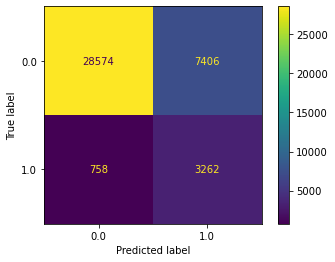

              precision    recall  f1-score   support

         0.0       0.97      0.79      0.87     35980
         1.0       0.31      0.81      0.44      4020

    accuracy                           0.80     40000
   macro avg       0.64      0.80      0.66     40000
weighted avg       0.91      0.80      0.83     40000

Accuracy of the model:  0.7959
Recall of the model:  0.8114427860696517
Precision of the model:  0.30577427821522307
F Measure of the model:  0.44417211328976025


In [ ]:
show_confusion_matrix(model, X_val, y_val)

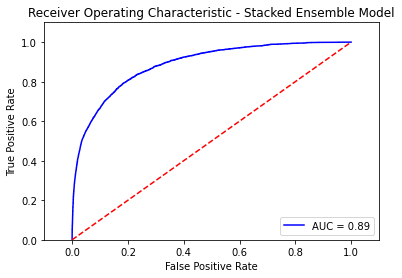

In [ ]:
plot_roc(model, X_val, y_val)

##### Save Model

In [ ]:
# save
pkl.dump(model, open(folder + 'charan/' + 
                     'lgbm_lr_xgb_stack_20220420.pkl.dat', 
                     "wb"))
# load
# xgb_stack_loaded = pkl.load(open(folder + "charan/" +
#                    "lgbm_lr_xgb_stack_20220420.pkl.dat", "rb"))

##### Creating kaggle csv for submission

In [ ]:
def kaggle_submission(model, X_test_all):
    y_pred = model.predict_proba(X_test_all)
    kaggle = pd.DataFrame({
        'ID_code': X_test_all.index.map(lambda x: 'test_{}'.format(x)),
        'target': y_pred[:,1]})
    kaggle = kaggle.set_index('ID_code')
    return kaggle

In [ ]:
kaggle_submission(model, X_test_all).to_csv(folder + 'charan/kaggle9.csv')

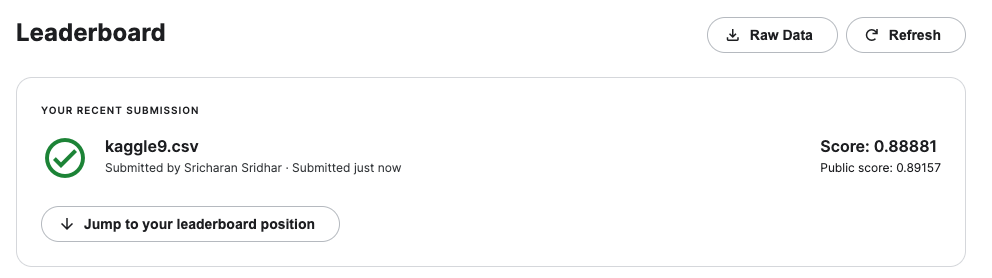